In [1]:
import cupy as cp
import numpy as np

if cp.cuda.is_available():
	print("GPU is available")
	print("GPU: ", cp.cuda.runtime.getDeviceProperties(0)['name'])

GPU is available
GPU:  b'NVIDIA GeForce RTX 4070 SUPER'


In [2]:
import os
import tempfile
from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

C:\Users\cordo\AppData\Roaming\Python\Python310\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


In [3]:
MAKE_ANIMATIONS = True
tempdir = tempfile.TemporaryDirectory()

def make_video_from_solution(
    solution,
    quantities=("order_parameter", "phase"),
    fps=20,
    figsize=(5, 4),
):
    """Generates an HTML5 video from a tdgl.Solution."""
    with tdgl.non_gui_backend():
        with h5py.File(solution.path, "r") as h5file:
            anim = create_animation(
                h5file,
                quantities=quantities,
                fps=fps,
                figure_kwargs=dict(figsize=figsize),
            )
            video = anim.to_html5_video()
        return HTML(video)


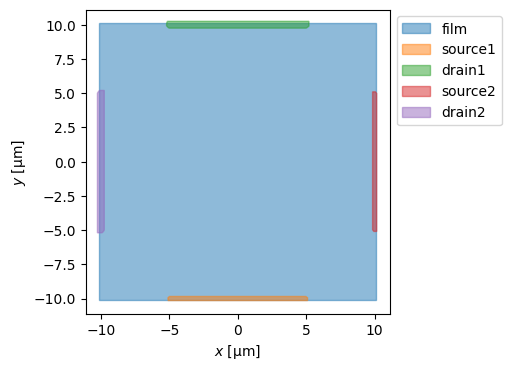

In [4]:
length_units = "um"
# Material parameters
xi = 0.5
london_lambda = 2
d = 0.1
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

width = 20
height = 20

film = (
	tdgl.Polygon('film', points=box(width, height)).resample(401).buffer(0.1)
)

source1 = tdgl.Polygon('source1', points=box(10,0.1)).translate(0, -height/2 ).buffer(0.1).resample(401)
drain1 = source1.scale(yfact=-1).set_name("drain1").buffer(0.1).resample(401)
source2 = tdgl.Polygon('source2', points=box(0.1,10)).translate( width/2,0).buffer(0.1).resample(401)
drain2 = source2.scale(xfact=-1).set_name("drain2").buffer(0.1).resample(401)
device=tdgl.Device("2currents",
				   layer=layer 
				   ,film=film
				   ,terminals= [source1,drain1,source2,drain2]
				   ,length_units=length_units
				   )

fig,ax=device.draw()

In [5]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons:   0%|          | 0/21816 [00:00<?, ?it/s]Malformed Voronoi cell surrounding boundary site 1. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 2. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 78. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 79. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 91. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a sm

In [6]:
device.mesh_stats()

num_sites,21816
num_elements,43138
min_edge_length,6.824e-02
max_edge_length,2.511e-01
mean_edge_length,1.484e-01
min_area,4.111e-03
max_area,3.853e-02
mean_area,1.871e-02
coherence_length,5.000e-01
length_units,um


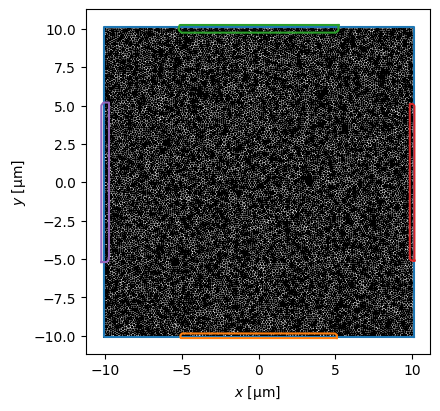

In [7]:
fig, ax = device.plot(mesh=True, legend=False)

In [8]:
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100,
    solve_time=150,
    output_file=os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
)

zero_field_solution = tdgl.solve(
						device,
						options,
						# terminal_currents must satisfy current conservation, i.e.,
						# sum(terminal_currents.values()) == 0.
						terminal_currents=dict(source1=12, drain1=-12, source2=12, drain2=-12)
					)

The terminal currents are non-null, but the device has no probe points.
Simulating: 100%|█████████▉| 150/150 [00:21<00:00,  6.85tau/s ]


In [9]:
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100,
    solve_time=150,
    output_file=os.path.join(tempdir.name, "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
	gpu=True
)

zero_field_solution = tdgl.solve(
						device,
						options,
						# terminal_currents must satisfy current conservation, i.e.,
						# sum(terminal_currents.values()) == 0.
						terminal_currents=dict(source1=12, drain1=-12, source2=12, drain2=-12)
					)

The terminal currents are non-null, but the device has no probe points.
Output file already exists. Renaming to C:\Users\cordo\AppData\Local\Temp\tmpew076uww\weak-link-zero-field-1.h5.
Simulating: 100%|█████████▉| 150/150 [00:28<00:00,  5.23tau/s ]


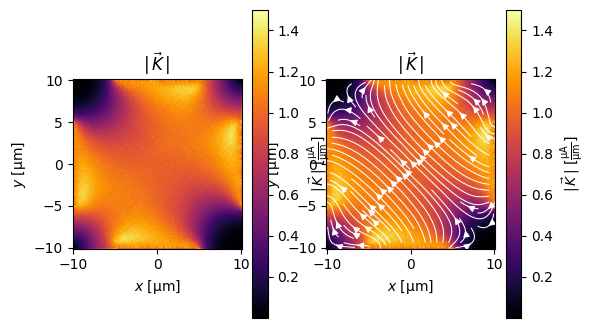

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))
_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])

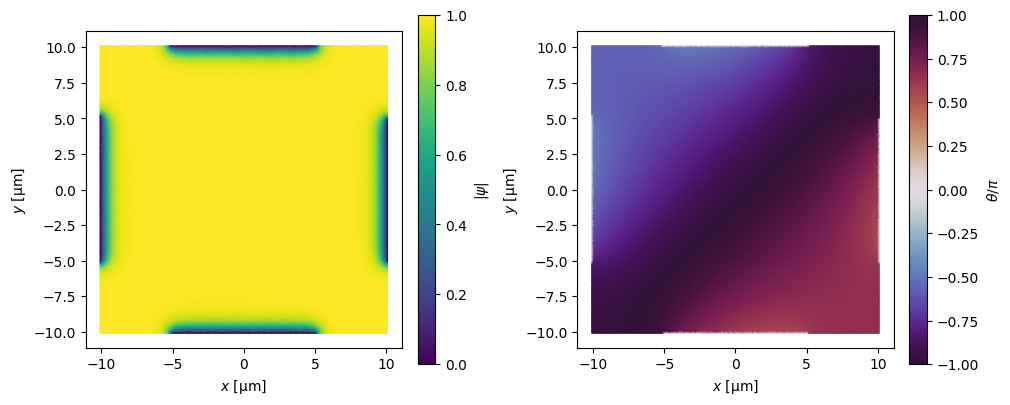

In [11]:
zero_field_solution.solve_step = zero_field_solution.closest_solve_step(50000)
fig, axes = zero_field_solution.plot_order_parameter(figsize=(10, 4))

Output file already exists. Renaming to C:\Users\cordo\AppData\Local\Temp\tmpew076uww\weak-link-zero-current-4.h5.
Simulating: 100%|█████████▉| 200/200 [04:24<00:00,  1.32s/tau ]     


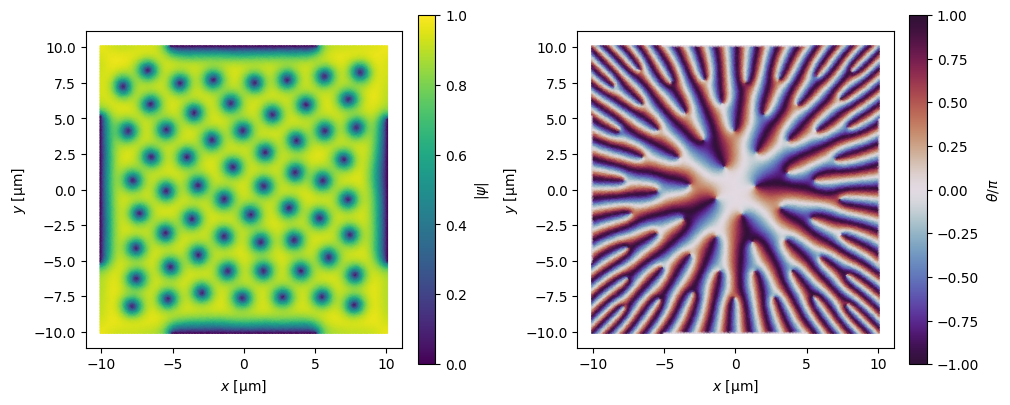

In [19]:


import tdgl.sources


options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join(tempdir.name, "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",
	gpu=True
)
applied_vector_potential=tdgl.sources.constant.ConstantField(0.4,field_units=options.field_units,length_units=device.length_units)
zero_current_solution = tdgl.solve(
	device=device,
	options=options,
	applied_vector_potential=applied_vector_potential,
)
fig, axes = zero_current_solution.plot_order_parameter(figsize=(10, 4))

In [24]:
options = tdgl.SolverOptions(
    solve_time=600,
    output_file=os.path.join(tempdir.name, "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",
)
applied_vector_potential=tdgl.sources.constant.ConstantField(0.4,field_units=options.field_units,length_units=device.length_units)
current_n_field_solution = tdgl.solve(
	device=device,
	options=options,
	applied_vector_potential=applied_vector_potential,
	terminal_currents=dict(source1=12, drain1=-12, source2=12, drain2=-12)
)


The terminal currents are non-null, but the device has no probe points.
Output file already exists. Renaming to C:\Users\cordo\AppData\Local\Temp\tmpew076uww\weak-link-zero-current-6.h5.
Simulating: 100%|█████████▉| 600/600 [16:02<00:00,  1.60s/tau ]     


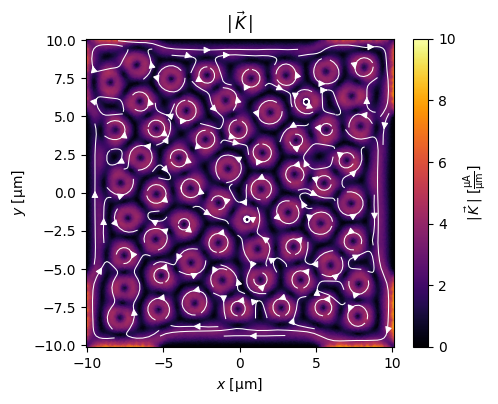

In [22]:
fig, ax = zero_current_solution.plot_currents(min_stream_amp=0.075, vmin=0, vmax=10)

In [23]:
if MAKE_ANIMATIONS:
    field_current_video = make_video_from_solution(
        current_n_field_solution,
        quantities=["order_parameter", "phase"],
        figsize=(6.5, 4),
    )
    display(field_current_video)